# Real-world data experiment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import DotProduct,RBF,Matern,RationalQuadratic

In [2]:
np.random.seed(0)

# LRCS Data

## Loading and pre-processing LRCS data

We load the LRCS data. We prepare the data by perfoming the following operations:
1. We drop non-relevant target variables;
2. (We get a sample by averaging together measurements with the same control variables;)
3. We drop non-relevant control variables.

In [3]:
df_LRCS = pd.read_csv('data/batteries/LRCS_Dataset.csv',sep=';',decimal=',')
df_LRCS.drop(df_LRCS.columns[[5,6]], axis=1, inplace=True)
df_LRCS.head()

,Composition (A.M.%),S-to-L Ratio (%),Comma gap (µm),Viscosity (Pas),Mass Loading (mg cm-2)
0,96.0,73.291013,50,3.1,7.508698
1,96.0,73.291013,50,3.1,7.579602
2,96.0,73.291013,50,3.1,6.941469
3,96.0,73.291013,50,3.1,7.437795
4,96.0,73.291013,50,3.1,7.225084


We average the eight samples with the same four control parameters.

We keep two control variables (*AM composition, comma gap*) and one target variable (*mass loading*).

In [4]:
df_LRCS.drop(df_LRCS.columns[[1,3]], axis=1, inplace=True)

This is our starting LRCS dataset.

In [5]:
df_LRCS.head()

,Composition (A.M.%),Comma gap (µm),Mass Loading (mg cm-2)
0,96.0,50,7.508698
1,96.0,50,7.579602
2,96.0,50,6.941469
3,96.0,50,7.437795
4,96.0,50,7.225084


# WMG Data

## Loading and preprocessing WMG data

We load the WMG data. 

### Control variables 
We start from the data containing information about the control variables. We prepare this data by perfoming the following operations:
1. We retain only data about timing, comma bar gap and roll gear ratio;
2. We convert the comma bar measure from mm to µm, and we multiply it by the roll gear ratio to have a measure consistent with the LRCS data;
3. We enrich the data with the known AM control variable.

In [6]:
df_comma = pd.read_csv('data/batteries/WMG_DataComma.csv',sep=',',decimal='.')
df_comma.head()

,Row Number,Date,Time,Comma Bar Op Position SP (mm),Comma Bar Op Position Actual (mm),Comma Bar Gr Position SP (mm),Comma Bar Gr Position Actual (mm),Bump Roll Op Position SP (mm),Bump Roll Op Position Actual (mm),Bump Roll Gr Position SP (mm),...,bump_position_slave_row_7 (mm),Patch length Actual (mm),Skip (MFZ) length Actual (mm),Side A Pos. Actual (mm),Side B Pos. Actual (mm),Correction Dist. Actual (mm),Product offset value Actual,Sensor offset value Actual,Reg. Enabled/Disabled,Reg. Data Okay or Not Okay
0,1,11/04/2020,09:13:23,0.0,0.0,-0.004,-0.004,1.250,1.250,1.069,...,0.0,987.784,11.096,520.997,0.0,-442.0,0.0,442.0,1.0,0.0
1,2,11/04/2020,09:13:24,0.0,0.0,-0.004,-0.004,1.250,1.250,1.070,...,0.0,987.784,11.096,520.997,0.0,-442.0,0.0,442.0,1.0,0.0
2,3,11/04/2020,09:13:25,0.0,0.0,-0.004,-0.004,1.251,1.251,1.070,...,0.0,987.784,11.096,520.997,0.0,-442.0,0.0,442.0,1.0,0.0
3,4,11/04/2020,09:13:26,0.0,0.0,-0.004,-0.004,1.251,1.251,1.070,...,0.0,987.784,11.096,520.997,0.0,-442.0,0.0,442.0,1.0,0.0
4,5,11/04/2020,09:13:27,0.0,0.0,-0.004,-0.004,1.251,1.251,1.071,...,0.0,987.784,11.096,520.997,0.0,-442.0,0.0,442.0,1.0,0.0


In [7]:
df_comma['Coating Roll Gear Ratio Setpoint'].unique()

array([100., 130., 118., 150., 142., 125.])

In [8]:
len(df_comma)

12198

In [9]:
df_coater = df_comma[['Time', 'Comma Bar Op Position Actual (mm)', 'Coating Roll Gear Ratio Setpoint']].copy()

In [10]:
df_coater['Comma Bar Op Position Actual (µm)'] = df_coater['Comma Bar Op Position Actual (mm)']*1000*df_coater['Coating Roll Gear Ratio Setpoint']/100

In [11]:
df_coater['Comma Bar Op Position Actual (µm)'].unique()

array([  0.  , 143.  ,   1.3 , 161.2 , 169.  ,   2.6 ,   5.2 ,  -1.3 ,
       108.56,   1.18,   1.5 , 165.  , 166.5 , 144.3 ,  -3.9 ,  -2.6 ,
       152.22, 151.04,   2.36,   3.9 ,   4.26, 181.76,   1.42,   2.84,
         7.8 , 150.  ,  91.5 ,   3.  ,  93.  , 147.  , 145.5 ,   4.5 ,
         1.25,   5.  ,   2.5 , 106.25,   3.75,   7.5 ,   6.25, 180.  ,
         6.  ,   9.  ,  13.5 , 182.  ,  10.4 ,   6.5 ])

In [12]:
df_coater['AM'] = 96.0

### Measurement variables
We then load the measurement data. We prepare this data by perfoming the following operations:
1. We compute average measurements from $n_{avg\_points}$ spatial locations at the center of the plaque;
2. We convert the measurements from $g \cdot m^{-2}$ to $mg \cdot cm^{-2}$ to be consistent with the LRCS data.

In [13]:
df_dry = pd.read_csv('data/batteries/WMG_DataDry.dat',header=None,delim_whitespace=True)
df_dry.head()

,0,1,2,3,4,5,6,7,8,9,...,795,796,797,798,799,800,801,802,803,804
0,04.11.2020,10:05:00,1,0.000,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN
1,04.11.2020,10:05:08,1,0.000,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN
2,04.11.2020,10:05:16,1,0.000,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN
3,04.11.2020,10:05:24,1,0.004,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN
4,04.11.2020,10:05:32,1,0.010,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN


In [14]:
len(df_dry)

1460

In [15]:
n_averaging_locations = 2

def df_getcentralavg_in_mg_cm2(df,low=350,high=450,colname='avg'):
    df[colname] = df.iloc[:,low:high].mean(axis=1) / 10

avg_names = []
basevalue = 353
step = np.int32(np.floor(100/n_averaging_locations))
for i in range(n_averaging_locations):
    df_getcentralavg_in_mg_cm2(df_dry,
                    low = basevalue+(i*step),
                    high = basevalue+((i+1)*step),
                    colname = 'avg'+str(i) )
    avg_names.append('avg'+str(i))

### Aligning control and measurements 
Last we need to align the data into a new dataframe. We start observing the comma bar data.

<AxesSubplot:>

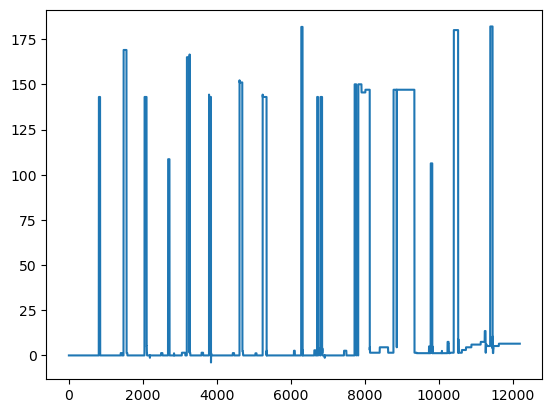

In [16]:
df_coater['Comma Bar Op Position Actual (µm)'].plot()

We distinguish 15 spikes corresponding to 15 different experimental settings. We now try to extract the intervals and the values in these spikes.

In [17]:
def get_on_off_points(data,mask,start=None,stop=None):
    if not(start): start = 0
    if not(stop): stop = len(mask)
    
    on = False
    onpoint = None
    
    onpoints = []
    offpoints = []
    cgs = {}
    for i in range(start,stop):
        if not(on):
            if mask[i]==True:
                on = True
                onpoint = i
                onpoints.append(i)
                cgs[str(onpoint)] = [data[i]]
        else:
            if mask[i]==False:
                offpoints.append(i)
                on = False
            else:
                cgs[str(onpoint)].append(data[i])
                
    return onpoints, offpoints, cgs

In [18]:
mask = df_coater['Comma Bar Op Position Actual (µm)'] > 40
onpoints, offpoints, cgs = get_on_off_points(df_coater['Comma Bar Op Position Actual (µm)'], mask)

In [19]:
cg_labels = []
for i in range(len(onpoints)):  
    print('\n ({0}) {1} - {2} ({3}):'.format(i+1, onpoints[i],offpoints[i], offpoints[i]-onpoints[i]))
    print('{0}'.format(cgs[str(onpoints[i])]))
    cg_labels.append(np.median(cgs[str(onpoints[i])]))


 (1) 809 - 844 (35):
[143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0]

 (2) 1478 - 1558 (80):
[161.2, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0]

 (3) 2045 - 2101 (56):
[143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143.0, 143

Notice that we have 19 intervals because four times, during the setting of the comma gap, the recording shortly fell to zero. In particular we aggregate in the same spike:
- Interval 5 and 6, both having $CG=165$, but separated by a one-second drop to $CG=0$;
- Interval 11 and 12, both having $CG=143$, but separated by a one-minute drop to $CG=0$;
- Interval 13 and 14, both having $CG \approx 150$, but separated by a one-minute drop to $CG=0$;
- Interval 15 and 16, both having $CG=147$, but separated by a one-second drop to $CG=0$.

In [20]:
set(cg_labels)

{106.25,
 108.56,
 143.0,
 147.0,
 150.0,
 151.04,
 165.0,
 169.0,
 180.0,
 181.76,
 182.0}

Thus in total we have $CG$ setting in the set: $\{85, 92, 98, 100, 110, 120, 128, 130, 140 \}$.

We now turn our attention to the mass loading dataset.

<AxesSubplot:>

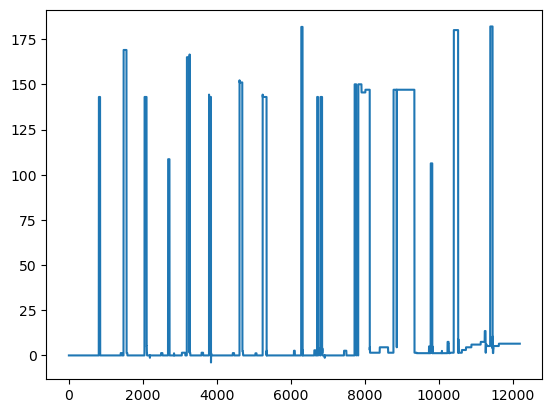

In [21]:
df_coater['Comma Bar Op Position Actual (µm)'].plot()

<AxesSubplot:>

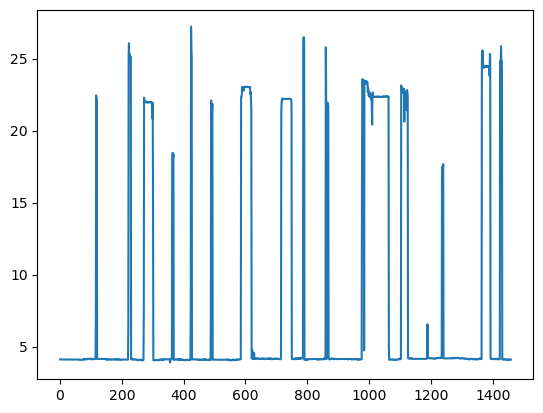

In [22]:
df_dry['avg0'].plot()

We get 15 spikes here as well. As before we extract the intervals.

In [23]:
mask = df_dry['avg0'] > 10
onpoints, offpoints, mls = get_on_off_points(df_dry['avg0'], mask)

In [24]:
for i in range(len(onpoints)):  
    print('\n ({0}) {1} - {2} ({3}):'.format(i+1, onpoints[i],offpoints[i], offpoints[i]-onpoints[i]))
    print('{0}'.format(np.mean(mls[str(onpoints[i])])))


 (1) 117 - 120 (3):
22.267693333333327

 (2) 222 - 230 (8):
25.2082975

 (3) 272 - 302 (30):
21.687307999999994

 (4) 363 - 368 (5):
18.297356

 (5) 424 - 427 (3):
25.973060000000004

 (6) 489 - 494 (5):
21.495748000000003

 (7) 586 - 620 (34):
22.844512352941177

 (8) 716 - 750 (34):
22.15215117647059

 (9) 787 - 791 (4):
26.40842

 (10) 860 - 862 (2):
24.53900000000001

 (11) 864 - 869 (5):
21.821416

 (12) 977 - 984 (7):
22.214468571428572

 (13) 985 - 1064 (79):
22.495755696202536

 (14) 1104 - 1126 (22):
22.57285909090909

 (15) 1236 - 1241 (5):
17.300688

 (16) 1365 - 1393 (28):
24.612877857142852

 (17) 1424 - 1431 (7):
24.818802857142856


We now have 17 intervals, but a look at the data reveals that we can aggregate two intervals:
- Interval 10 and 11, separated by a two timesteps drop to $0$;
- Interval 12 and 13, separated by a one timestep drop to $0$.

We now redefine CG labels to align with our ML measurements.

In [25]:
cg_labels.pop(15); cg_labels.pop(5)
print(cg_labels)

[143.0, 169.0, 143.0, 108.56, 165.0, 143.0, 151.04, 143.0, 181.76, 143.0, 143.0, 150.0, 147.0, 147.0, 106.25, 180.0, 182.0]


Finally, we build our dataset.

In [26]:
data = {
    'CG': [],
    'AM': [],
}
for n in range(n_averaging_locations):
    data['ML_avg'+str(n)] = []

In [27]:
for i in range(len(onpoints)):
    for j in range(offpoints[i]-onpoints[i]):
        data['CG'].append(cg_labels[i])
        data['AM'].append(96.0)
        for n in range(n_averaging_locations):
            data['ML_avg'+str(n)].append(df_dry['avg'+str(n)][onpoints[i]+j])


In [28]:
df_WMG = pd.DataFrame(data=data)
df_WMG.head()

,CG,AM,ML_avg0,ML_avg1
0,143.0,96.0,22.44898,22.31306
1,143.0,96.0,22.19144,22.06854
2,143.0,96.0,22.16266,21.80864
3,169.0,96.0,25.08116,24.92084
4,169.0,96.0,26.07010,25.85620


In [29]:
len(df_WMG)

281

# Abstraction

## Further preprocessing

In our abstraction WMG will be the low-level model (higher spatial resolution, higher resolution for CG), while LRCS be the high-level model.

In [30]:
df_LRCS.head()

,Composition (A.M.%),Comma gap (µm),Mass Loading (mg cm-2)
0,96.0,50,7.508698
1,96.0,50,7.579602
2,96.0,50,6.941469
3,96.0,50,7.437795
4,96.0,50,7.225084


In [31]:
df_WMG.head()

,CG,AM,ML_avg0,ML_avg1
0,143.0,96.0,22.44898,22.31306
1,143.0,96.0,22.19144,22.06854
2,143.0,96.0,22.16266,21.80864
3,169.0,96.0,25.08116,24.92084
4,169.0,96.0,26.07010,25.85620


The LRCS has a lower resolution, but a larger set of parameters. To allow for abstraction we will narrow this sets. We perform the following operations:

1. Since we have a single value of $AM$ in WMG, this parameter is not very informative. We drop it from WMG, and subselect for $AM=96.0$ in LRCS.
2. We limit the values of $CG$ in LRCS to $\{75,100,200\}$.
3. We try to extrapolate values for $CG$ at $\{75,200\}$ in WMG.
4. We limit the values of $CG$ in WMG to $\{75,110,150,170,180,200\}$.

We remove $AM$.

In [32]:
df_WMG.drop(columns=['AM'],axis=1,inplace=True)

In [33]:
df_LRCS = df_LRCS[df_LRCS['Composition (A.M.%)']==96]
df_LRCS.drop(columns=['Composition (A.M.%)'],axis=1,inplace=True)

We subselect $CG$.

In [34]:
cond = np.logical_and(df_LRCS['Comma gap (µm)']!=50, 
                      np.logical_and(df_LRCS['Comma gap (µm)']!=300,df_LRCS['Comma gap (µm)']!=400))
df_LRCS = df_LRCS[cond]

We prepare data to extrapolate.

In [35]:
xs = np.array(list(df_WMG['CG'])*n_averaging_locations)
xs = np.expand_dims(xs,axis=1)

In [36]:
ys = []
for n in range(n_averaging_locations):
    ys += list(df_WMG['ML_avg'+str(n)])
ys = np.array(ys)

We look at the data

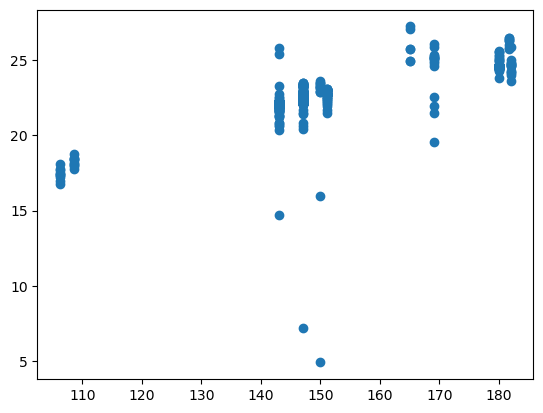

In [37]:
plt.scatter(xs,ys)

In [38]:
len(xs)

562

We remove a few outliers

In [39]:
np.sum(ys<15)

3

In [40]:
xs = xs[ys>15]
ys = ys[ys>15]

We define a GP with a linear kernel to extrapolate beyond the given domain

/Users/giofelekis/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


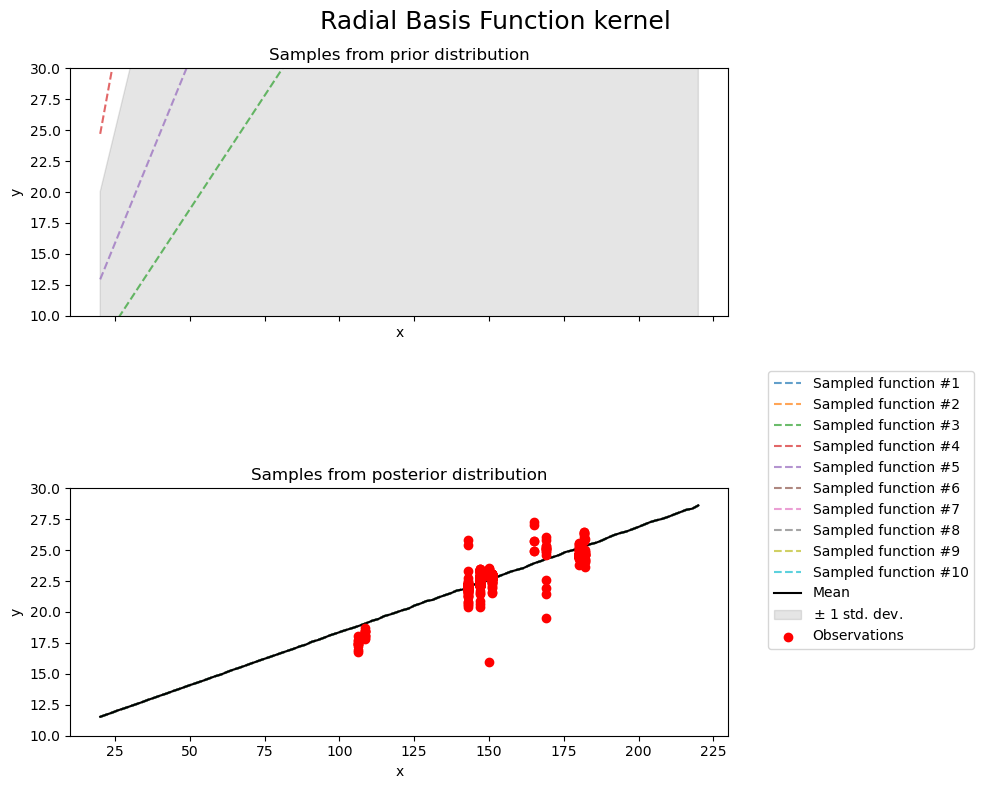

In [41]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(20, 220, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([10, 30])

kernel = DotProduct()
#kernel = 1.0 * RBF(length_scale=10.0)
#kernel = 1.0 * Matern(length_scale=1.0, nu=3)
#kernel = 10.0 * RationalQuadratic(length_scale=2.0, alpha=1.0)
model = GPR(kernel=kernel,normalize_y=True,alpha=1e-8)
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(model, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
model.fit(xs,ys)
plot_gpr_samples(model, n_samples=10, ax=axs[1])
axs[1].scatter(xs[:, 0], ys, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()

In [42]:
len(df_WMG)

281

We add to the WMG data 20 datapoints for $CG=\{50,200\}$ each.

In [43]:
extrap_cgs = [75,200]
n_extrap_points = 20

extrap_data = {
    'CG': [],
}
for n in range(n_averaging_locations):
    extrap_data['ML_avg'+str(n)] = []

for cg in extrap_cgs: 
    extrap_data['CG'] += [cg]*n_extrap_points
    for n in range(n_averaging_locations):
        extrap_data['ML_avg'+str(n)] += list(model.sample_y(np.array([[cg]]),n_samples=n_extrap_points,random_state=n)[0])

df_extrap = pd.DataFrame(data=extrap_data)

In [44]:
df_WMG.iloc[-10:-1,:]

,CG,ML_avg0,ML_avg1
271,180.0,23.80490,24.24394
272,180.0,25.32966,24.94768
273,180.0,25.17050,24.66448
274,182.0,24.82478,25.02512
275,182.0,24.64324,24.59812
276,182.0,24.70754,24.24422
277,182.0,25.86620,24.00474
278,182.0,24.64712,24.14018
279,182.0,24.82550,24.62126


In [45]:
df_WMG = pd.concat([df_WMG,df_extrap],ignore_index=True)
len(df_WMG)

321

We subselect $CG$.

In [46]:
np.sort(df_WMG['CG'].unique())

array([ 75.  , 106.25, 108.56, 143.  , 147.  , 150.  , 151.04, 165.  ,
       169.  , 180.  , 181.76, 182.  , 200.  ])

In [47]:
df_WMG['CG'][df_WMG['CG']==106.25] = 110
df_WMG['CG'][df_WMG['CG']==108.56] = 110
df_WMG['CG'][df_WMG['CG']==147] = 150
df_WMG['CG'][df_WMG['CG']==151.04] = 150
df_WMG['CG'][df_WMG['CG']==169] = 170
df_WMG['CG'][df_WMG['CG']==181.76] = 180
df_WMG['CG'][df_WMG['CG']==182] = 180

In [48]:
np.sort(df_WMG['CG'].unique())

array([ 75., 110., 143., 150., 165., 170., 180., 200.])

In [49]:
cond = np.logical_or(df_WMG['CG']==75, 
                     np.logical_or(df_WMG['CG']==110,
                                  np.logical_or(df_WMG['CG']==150,
                                               np.logical_or(df_WMG['CG']==170,
                                                            np.logical_or(df_WMG['CG']==180,df_WMG['CG']==200)))))                     
df_WMG = df_WMG[cond]
len(df_WMG)

239

Finally, we discretize.

In [50]:
print(df_LRCS['Mass Loading (mg cm-2) '].min(),df_LRCS['Mass Loading (mg cm-2) '].max())

9.75714407876113 29.7724497783002


In [51]:
print(df_WMG.iloc[:,2:].min().min(),df_WMG.iloc[:,2:].max().max())

4.897140000000001 26.88490292891129


In [52]:
ys = list(df_LRCS['Mass Loading (mg cm-2) '])
for n in range(n_averaging_locations):
    ys += list(df_WMG['ML_avg'+str(n)])
ys = np.array(ys)

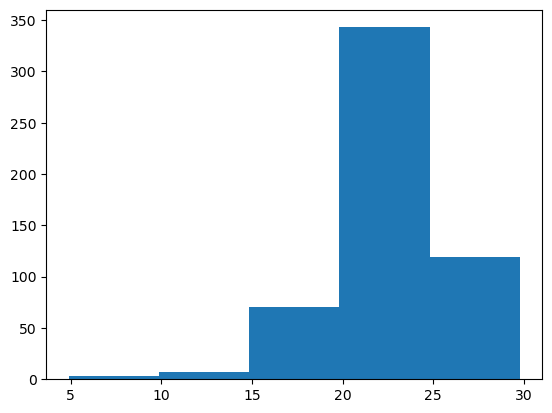

In [53]:
n_bins = 5
_,bins,_ = plt.hist(ys,bins=n_bins)

In [54]:
bins[0] -= 0.1; bins[-1] += 0.1

In [55]:
df_LRCS['binned ML'] = pd.cut(df_LRCS['Mass Loading (mg cm-2) '], bins=bins, labels=np.arange(len(bins)-1))

In [56]:
for n in range(n_averaging_locations):
    df_WMG['binned ML_avg'+str(n)] = pd.cut(df_WMG['ML_avg'+str(n)], bins=bins, labels=np.arange(len(bins)-1))
    

In [57]:
df_WMG

,CG,ML_avg0,ML_avg1,binned ML_avg0,binned ML_avg1
3,170.0,25.081160,24.920840,4,4
4,170.0,26.070100,25.856200,4,4
5,170.0,25.179620,24.823320,4,4
6,170.0,25.314200,25.295920,4,4
7,170.0,24.634940,19.529240,3,2
...,...,...,...,...,...
316,200.0,26.884871,26.884838,4,4
317,200.0,26.884897,26.884859,4,4
318,200.0,26.884858,26.884843,4,4
319,200.0,26.884870,26.884864,4,4


## Defining the SCM for the LRCS data 

For the LRCS data we assume a SCM made up of two variables, $CG, ML$ representing comma gap and mass loading. Their cardinalities are:

- $|CG| = 3$
- $|ML| = \textrm{n_bins}$

In [58]:
df_LRCS.head()

,Comma gap (µm),Mass Loading (mg cm-2),binned ML
8,200,27.361725,4
9,200,29.772450,4
10,200,27.290821,4
11,200,27.858051,4
12,200,26.936303,4


In [59]:
n_CG_LRCS = len(df_LRCS['Comma gap (µm)'].unique())
n_ML_LRCS = n_bins
dom_CG_LRCS = [75,100,200]
dom_ML_LRCS = np.arange(n_ML_LRCS)

Next, we need to define a mechanism $\mu: CG \rightarrow ML$ in the form of a stochastic matrix of shape $\textrm{n_bins} \times 4$. We postpone defining the mechanism until we assess the alignment of the models later.

In [60]:
mu = np.zeros((n_ML_LRCS, n_CG_LRCS))

c = 0
for j in dom_CG_LRCS:
    query = df_LRCS['binned ML'][df_LRCS['Comma gap (µm)']==j]
    column = query.value_counts(normalize=True,sort=False,ascending=True)
    mu[:,c] = column
    c += 1     

In [61]:
mu

array([[0.125     , 0.        , 0.        ],
       [0.875     , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.04166667],
       [0.        , 0.        , 0.95833333]])

### Creating a pgmpy object

Having defined our SCM data, we can now pack it in a standard *pgmpy* object that we will use to learn an abstraction.

In [62]:
M1 = BN([('CG','ML')])

cpdCG = cpd(variable='CG',
          variable_card=n_CG_LRCS,
          values=np.ones((n_CG_LRCS,1))/n_CG_LRCS,
          evidence=None,
          evidence_card=None)
cpdML = cpd(variable='ML',
          variable_card=n_ML_LRCS,
          values=mu,
          evidence=['CG'],
          evidence_card=[n_CG_LRCS])

M1.add_cpds(cpdCG,cpdML)
M1.check_model()

True

A couple of observations: (i) we named this object $M1$ because it will be the high-level model; (ii) we defined the distributions $P(AM)$ and $P(CG)$ as uniform, as they will have no effect on the learning of the abstraction.

## Defining the SCM for the WMG data 

For the WMG data we assume a SCM made up of $1 + i$ variables, $CG, ML_i$, similar to the LRCS model, but splitting the ML variables into $i$ variables representing recording at different spatial locations. Their cardinalities are:
- $|CG| = 6$
- $|ML_i| = 5$

In [63]:
n_CG_WMG = len(df_WMG['CG'].unique())
n_ML_WMG = n_ML_LRCS
dom_CG_WMG = [75,110,150,170,180,200]
dom_ML_WMG = dom_ML_LRCS

Next, we need to define a mechanism $\nu_i: CG \rightarrow ML_i$ in the form of a stochastic matrix of shape $\textrm{n_bins}^{\textrm{n_avg_points}} \times 6$.

In [64]:
nus = []

for n in range(n_averaging_locations):
    nu = np.zeros((n_ML_WMG, n_CG_WMG))
    c = 0
    for j in dom_CG_WMG:
        query = df_WMG[['binned ML_avg'+str(n)]][(df_WMG['CG']==j)]
        column = query.value_counts(normalize=True,sort=False,ascending=True)
        nu[:,c] = column
        c += 1
    nus.append(nu)

In [65]:
nus[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.00704225, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.99295775, 0.125     , 0.69230769,
        0.        ],
       [0.        , 0.        , 0.        , 0.875     , 0.30769231,
        1.        ]])

In [66]:
nus[1]

array([[0.        , 0.        , 0.01408451, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , 0.125     , 0.        ,
        0.        ],
       [0.        , 0.        , 0.98591549, 0.375     , 0.74358974,
        0.        ],
       [0.        , 0.        , 0.        , 0.5       , 0.25641026,
        1.        ]])

### Creating a pgmpy object

Having defined our SCM data, we can now pack it in a standard *pgmpy* object that we will use to learn an abstraction.

In [67]:
M0 = BN()
M0.add_node('CG')

cpdCG = cpd(variable='CG',
          variable_card=n_CG_WMG,
          values=np.ones((n_CG_WMG,1))/n_CG_WMG,
          evidence=None,
          evidence_card=None)
M0.add_cpds(cpdCG)

for n in range(n_averaging_locations):
    M0.add_edge('CG','ML'+str(n))
    cpdML = cpd(variable='ML'+str(n),
              variable_card=n_ML_WMG,
              values=nus[n],
              evidence=['CG'],
              evidence_card=[n_CG_WMG])
    M0.add_cpds(cpdML)

M0.check_model()

True

A couple of observations: (i) we named this object $M0$ because it will be the high-level model; (ii) we defined the distributions $P(AM)$ and $P(CG)$ as uniform, as they will have no effect on the learning of the abstraction.

# Persistence

We store all the objects we have produced.

In [68]:
joblib.dump(df_LRCS,'data/batteries/dfs/df_LRCS_bins_'+str(n_bins)+'.pkl')
joblib.dump(df_WMG,'data/batteries/dfs/df_WMG_bins_'+str(n_bins)+'_avg_'+str(n_averaging_locations)+'.pkl')
joblib.dump(M1,'data/batteries/scms/M_LRCS_bins_'+str(n_bins)+'.pkl')
joblib.dump(M0,'data/batteries/scms/M_WMG_bins_'+str(n_bins)+'_avg_'+str(n_averaging_locations)+'.pkl')

['data/batteries/scms/M_WMG_bins_5_avg_2.pkl']

In [69]:
M0

In [70]:
M0.nodes

NodeView(('CG', 'ML0', 'ML1'))

In [71]:
M1.nodes

NodeView(('CG', 'ML'))

In [72]:
df_LRCS['Comma gap (µm)'].unique()

array([200,  75, 100])

In [73]:
df_WMG['CG'].unique()

array([170., 110., 150., 180.,  75., 200.])